# Course 5: Control
## Part 1: PID Control in Python
#### By Jonathan L. Moran (jonathan.moran107@gmail.com)
From the Self-Driving Car Engineer Nanodegree programme offered at Udacity.

## 1. Introduction

In [1]:
#### Importing the required modules

In [2]:
import matplotlib as mpl
# Setting the default font to use with Matplotlib
mpl.rc('font', family='Times New Roman')
import matplotlib.pyplot as plt
import numpy as np
import random
from typing import List, Tuple

### Background

In this following section we implement several controllers, some with open-loop and others with closed-loop feedback, in order to manoeuvre a simulated robot towards a goal trajectory (denoted the "reference trajectory").

In this problem set-up we define our reference trajectory as a horizontal line situated about the $x$-axis origin. Our robot is placed in this 2D environment and has the following state variables:
* **Position** — 2D location $(x, y)$ of the robot in the environment;
* **Orientation** — heading angle $\theta$ (i.e., direction) of the robot.

In addition to these state variables, the robot is manoeuvred with respect to the following:
* **Steering angle** — angle $\delta$ to move the front-axel (used in kinematic bicycle motion model);
* **Distance** — total distance travelled in the given time-step.

In order to manoeuvre a turn, the [kinematic bicycle motion](https://dingyan89.medium.com/simple-understanding-of-kinematic-bicycle-model-81cac6420357) model is approximated for the given steering angle $\delta$ and robot `length` $L$. Here we add random noise to both the drift / distance measurements as well as the steering angle. These noise values have been sampled from a Gaussian normal distribution.

### 1.1. Proportional Control

[Proportional control](https://en.wikipedia.org/wiki/Proportional_control) is a type of linear open-loop [feedback](https://en.wikipedia.org/wiki/Feedback) [control system](https://en.wikipedia.org/wiki/Control_system) used to correct an error signal using proportional gain constant. This type of open-loop feedback controller can be expressed mathematically as:
$$
\begin{align}
    P_{\mathrm{out}} &= K_{p} e(t) + p_{0},
\end{align}
$$

where $P_{\mathrm{out}}$ is the output of the controller with instantaneous process error $e(t)$ and a proportional gain factor $K_{p}$. The controller output with zero error term, $p_{0}$ is assumed to be zero for our purposes in this notebook.

#### For robot trajectory tracking

In the case of the simulated robot, we assume a static gain factor $K_{p} = \tau$ applied to the control variable $e(t) = \mathrm{CTE}_{t}$. Here our cross-track error $\mathrm{CTE}$ is assumed to be the $y$-coordinate of the robot at the given time-step. This error signal is defined relative to the assumed horizontal reference trajectory about the $x$-axis. 

In order to correct for perturbations between the desired and actual steering angle commands being executed by the robot, the controller produces an output proportional to the error signal. Here, that is the cross-track error — the distance between the desired reference trajectory at $y = 0$ and the current position of the robot given by the $y$-coordinate value. The proportional gain factor $K_{p}$ is selected proportional to this error.

Since our Robot is a dynamical system, we assume the presence of both measurement steering / distance noise as well as steering process noise. The proportional gain controller is used to counter-act this error. As we will see in the produced graphs, the robot is able to successfully reach the target reference trajectory after some elapsed time; however, with this open-loop proportional-gain controller we notice the presence of oscillations about the reference trajectory. In other words, the robot "overshoot" the reference trajectory before settling at the target. 

### 1.2. Proportional-Derivative Control

#### For robot trajectory tracking

## 2. Programming Task

In this section we implement the open- and closed-loop feedback controllers and demonstrate their performance in trajectory tracking using a simulated robot. See Sect. 1: Background for more information on the `Robot` class implemented below.

#### The `Robot`  class

In [3]:
class Robot(object):
    '''The simulated Robot class.
    
    The robot moves about the 2D environment given a position (x, y) and
    heading (`orientation`) angle, i.e., direction of motion.

    :param x: Position of the robot along the $x$-axis.
    :param y: Position of the robot along the $y$-axis.
    :param orientation: Heading angle of the robot, i.e.,
        the direction parameter $\theta$ used in the bicycle motion model.
    :param length: Length of the robot, i.e.,
        the parameter $L$ used in the bicycle motion model.
    :param steering_noise: Steering measurement noise sampled from a
        Gaussian normal distribution.
    :param distance_noise: Distance measurement noise sampled from a
        Gaussian normal distribution.
    :param steering_drift: Perturbation of the steering angle sampled from a
        Gaussian normal distribution.
    '''

    def __init__(self,
            length: float=20.0
    ):
        """Creates a `Robot` instance.

        Initialises the robot 2D location and orientation angle to the
        position along the origin (0, 0) with a heading of `0.0`.

        :param length: Desired length to initialise the robot with. 
        """

        self.x = 0.0
        self.y = 0.0
        self.orientation = 0.0
        self.length = length
        self.steering_noise = 0.0
        self.distance_noise = 0.0
        self.steering_drift = 0.0

    def set(self, 
            x: float, 
            y: float,
            orientation: float
    ):
        """Sets the robot's 2D location and orientation to the given values.
        
        :param x: Position along the $x$-axis to assign to the robot.
        :param y: Position along the $y$-axis to assign to the robot.
        :param orientation: Heading angle to assign to the robot. 
        """

        self.x = x
        self.y = y
        self.orientation = orientation % (2.0 * np.pi)

    def set_noise(self, 
            steering_noise: float, 
            distance_noise: float
    ):
        """Sets the steering- and measurement- noise parameters.

        This update function allows for the use of dynamic noise values,
        which is often useful in particle filters.

        :param steering_noise: Noise value to use for the steering measurement.
        :param distance_noise: Noise value to use for the distance measurement.
        """

        self.steering_noise = steering_noise
        self.distance_noise = distance_noise

    def set_steering_drift(self, 
            drift: float
    ):
        """Sets the systematical steering drift parameter.

        :param drift: Drift value to use for the steering angle.
        """

        self.steering_drift = drift

    def move(self, 
            steering: float, 
            distance: float, 
            tolerance: float=0.001, 
            max_steering_angle: float=np.pi / 4.0
    ):
        """Move the robot to the next time-step with the provided controls.

        :param steering: Front-wheel steering angle $\delta$.
        :param distance: Total distance travelled by vehicle in this time-step,
            must be non-negative.
        :param tolerance: Tolerance value for the manoeuvre,
            values outside this threshold indicate a turning manoeuvre.
        :param max_steering angle: Maximum front-wheel steering angle.
        """

        # Thresholding of input steering angle and distance values 
        if steering > max_steering_angle:
            steering = max_steering_angle
        if steering < -max_steering_angle:
            steering = -max_steering_angle
        if distance < 0.0:
            distance = 0.0
        # Computing the noise values
        steering2 = random.gauss(steering, self.steering_noise)
        distance2 = random.gauss(distance, self.distance_noise)
        # Applying the steering drift parameter to the steering angle
        steering2 += self.steering_drift
        # Compute the radius of the turn / manoeuvre to execute
        turn_radius = np.tan(steering2) * distance2 / self.length
        if abs(turn_radius) < tolerance:
            # Compute the straight-line distance approximation of the manoeuvre
            self.x += distance2 * np.cos(self.orientation)
            self.y += distance2 * np.sin(self.orientation)
            self.orientation = (self.orientation + turn_radius) % (2.0 * np.pi)
        else:
            # Evaluate the approximate kinematic bicycle motion model
            # for the desired turning manoeuvre
            radius = distance2 / turn_radius
            # Compute the changing rate of $x$, $y$, $\delta$
            cx = self.x - (np.sin(self.orientation) * radius)
            cy = self.y + (np.cos(self.orientation) * radius)
            self.orientation = (self.orientation + turn_radius) % (2.0 * np.pi)
            self.x = cx + (np.sin(self.orientation) * radius)
            self.y = cy - (np.cos(self.orientation) * radius)

    def __repr__(self):
        """Overrides the default print function with vehicle state values."""
        return '[x=%.5f y=%.5f orient=%.5f]' % (self.x, self.y, self.orientation)

### 2.1. Proportional Control

Here we implement the proportional gain controller as defined in the `run` method below.

In [4]:
### From J. Moran's `1_proportional_control.py`

In [5]:
def run(
        robot: Robot, 
        tau: float, 
        n: int=100, 
        speed: float=1.0
) -> Tuple[List[float], List[float]]:
    """Simulates the robot movement across `n` time-steps.

    The proportional controller used here follows the equation:
        $\alpha = -\tau * \mathrm{CTE}$,
    where the steering input angle $\alpha$ is computed w.r.t. the
    cross-track error $\mathrm{CTE}$ which is proportional to the gain
    factor $\tau$ (i.e., the "response strength"). 
    
    The proportional controller implemented here is used to direct the
    robot motion towards the horizontal reference trajectory by giving
    steering angle commands computed w.r.t. the normally-distributed
    steering drift, as well as both steering- and distance measurement
    noise.

    :param robot: `Robot` class instance representing the vehicle to manoeuvre. 
    :param tau: Proportional gain constant.
    :param n: Number of time-steps to simulate.
    :param speed: Velocity (m/s) at which to drive the vehicle.
    """

    # The list of $x$- and $y$-values for the simulated trajectory
    x_trajectory = []
    y_trajectory = []
    # Simulate the robot movement across `n` time-steps
    for i in range(n):
        # Get the current cross-track error relative to reference trajectory
        cte = robot.y
        # Compute the steering angle w.r.t. the proportional gain controller
        steer = -tau * cte
        # Execute the steering command
        robot.move(steer, speed)
        # Append the updated robot position coordinates to the trajectory lists
        _x, _y = robot.x, robot.y
        x_trajectory.append(_x)
        y_trajectory.append(_y)
    return x_trajectory, y_trajectory

##### Testing the proportional gain controller

In [6]:
### From J. Moran's `1_proportional_control.py`

In [7]:
### Initialise the robot instance using default values
robot = Robot()
### Perform a single control run to position (0, 1)
# with heading angle `0.0`
robot.set(0.0, 1.0, 0.0)
### Execute the trajectory using the proportional controller            
x_trajectory, y_trajectory = run(robot, 0.1)

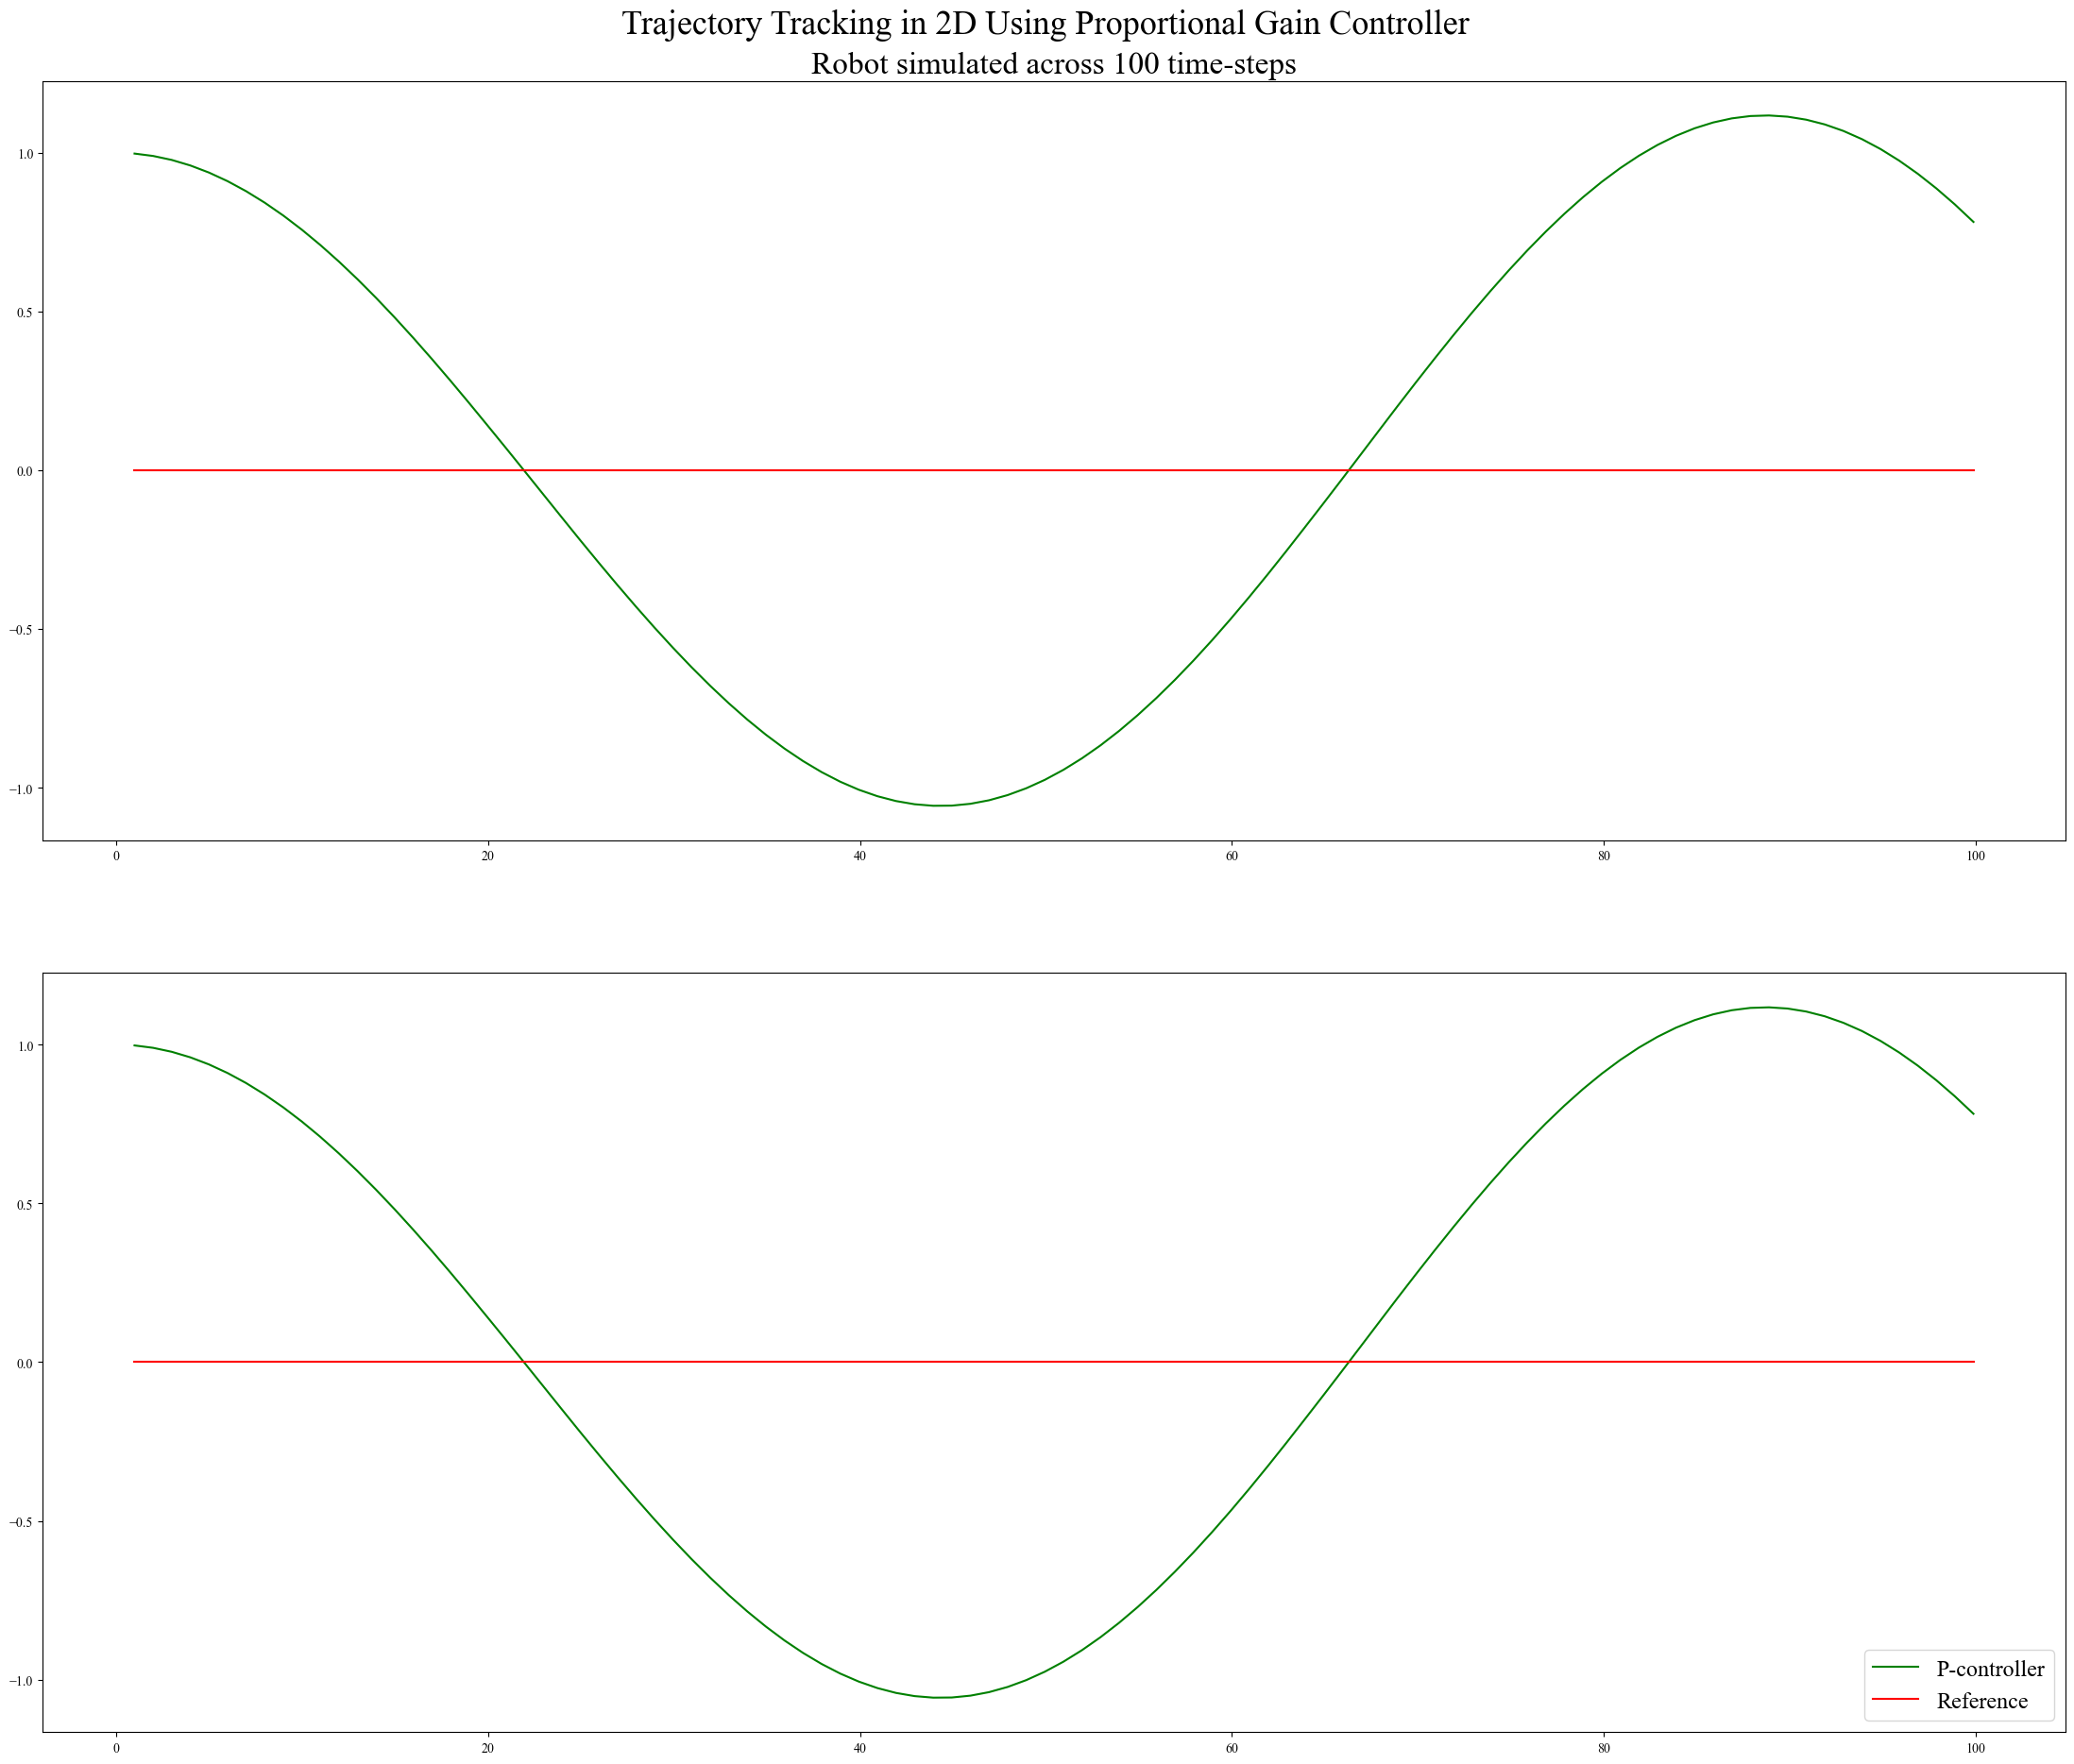

In [8]:
### Plot the robot position and orientation relative to the reference
fig, (ax1, ax2) = plt.subplots(2, 1,
        figsize=(24, 20)
)
plt.tight_layout(pad=8.0)
plt.suptitle('Trajectory Tracking in 2D Using Proportional Gain Controller',
        fontsize=26
)
ax1.set_title('Robot simulated across 100 time-steps',
        fontsize=24
)
ax1.plot(x_trajectory, y_trajectory,
        color='g', label='P-controller'
)
ax1.plot(x_trajectory, np.zeros(len(x_trajectory)),
        color='r', label='Reference'
)
ax2.plot(x_trajectory, y_trajectory, 
        color='g', label='P-controller'
)
ax2.plot(x_trajectory, np.zeros(len(x_trajectory)), 
        color='r', label='Reference'
)
plt.legend(loc='lower right', fontsize='xx-large')
plt.show()

### 2.2. Proportional-Derivative Control

Here we implement the proportional-derivative (PD) controller as defined in the `run_pd` method below.

In [ ]:
### From J. Moran's `2_proportional_derivative_control.py`

In [ ]:
def run_pd(
        robot: Robot, 
        tau_p: float,
        tau_d: float, 
        n: int=100, 
        speed: float=1.0
) -> Tuple[List[float], List[float]]:
    """Simulates robot movement using proportional-derivative control.

    The proportional-derivative controller used here follows the equation:
        $\alpha = -\tau_{p} * \mathrm{CTE} - \tau_{d} * \Delta \mathrm{CTE}$,
    where the steering input angle $\alpha$ is computed w.r.t. the proportional
    gain controller — i.e., the product of proportional gain $\tau_{p}$ (the
    "response strength") and the current cross-track error $\mathrm{CTE}_{t}$,
    and the derivative of the cross-track error $\Delta \mathrm{CTE}$, i.e., 
        $\frac{\mathrm{CTE}_{t} - \mathrm{CTE}_{t-1}}{\Delta t}$,
    scaled by a constant gain factor $\tau_{d}$. 
    
    Assumed here is a constant unit time-step $\Delta t = 1.0$ and a reference
    trajectory defined as a constant horizontal trajectory about the $x$-axis
    at $y=0$.
    
    The proportional-derivative controller implemented here is used to direct
    the robot motion towards the horizontal reference trajectory by giving
    steering angle commands computed w.r.t. both the normally-distributed
    steering drift and steering-, distance measurement noise.

    :param robot: `Robot` class instance representing the vehicle to manoeuvre. 
    :param tau_p: Proportional gain constant.
    :param tau_d: Anticipatory control constant for derivative control,
        used to control / dampen the influence of the rate-of-error change.
    :param n: Number of time-steps to simulate.
    :param speed: Velocity (m/s) at which to drive the vehicle.
    :returns: Set of x- and y-coordinates of the simulated trajectory.
    """

    # The list of $x$- and $y$-values for the simulated trajectory
    x_trajectory = []
    y_trajectory = []
    # Set the constant unit time-step value (used in derivative term)
    delta_t = 1.0
    # Initialise the "previous" and current cross-track error values
    cte_prev = robot.y
    cte_curr = 0.0
    # Simulate the robot movement across `n` time-steps
    for i in range(n):
        # Get the current cross-track error relative to reference trajectory
        cte_curr = robot.y
        # Compute the steering angle w.r.t. proportional-derivative controller
        # NOTE: `cte_dot` is derivative of CTE w.r.t. constant unit time-step
        cte_dot = (cte_curr - cte_prev) / delta_t
        # Compute the steering angle w.r.t. proportional and derivative gain
        steer = -tau_p * cte_curr - tau_d * cte_dot
        # Set the "previous" CTE value to the current error before manoeuvre
        cte_prev = cte_curr
        # Execute the steering command computed with the PD-controller
        robot.move(steer, speed)
        # Append the updated robot position coordinates to the trajectory lists
        _x, _y = robot.x, robot.y
        x_trajectory.append(_x)
        y_trajectory.append(_y)
    return x_trajectory, y_trajectory

#### Testing the proportional-derivative (PD) controller

Here we compare the performance of the PD controller to the previous proportional-gain controller.

In [ ]:
### From J. Moran's `2_proportional_derivative_control.py`

##### Experiment run with the proportional-gain controller

In [ ]:
### Initialise the robot instance using default values
robot = Robot()
### Perform a single control run to position (0, 1)
# with heading angle `0.0`
robot.set(0.0, 1.0, 0.0)
### Execute the trajectory first using the proportional-gain controller            
x_p_trajectory, y_p_trajectory = run(robot, 0.1)

##### Experiment run with the proportional-derivative controller

In [ ]:
 ### Re-initialise the robot to the starting PD-controller run
robot = Robot()
robot.set(0.0, 1.0, 0.0)
### Execute the trajectory using the proportional-derivative controller            
x_pd_trajectory, y_pd_trajectory = run_pd(robot, 0.2, 3.0)

##### Plotting and comparing the results

In [ ]:
### Plot the robot position and orientation relative to the reference
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1,
        figsize=(24, 20)
)
plt.tight_layout(pad=8.0)
suptxt = 'Trajectory Tracking in 2D Using Proportional and Proportional-Derivative Controller'
plt.suptitle(suptxt,
        fontsize=26
)
ax1.set_title('Robot simulated across 100 time-steps',
        fontsize=24
)
ax1.plot(x_pd_trajectory, y_pd_trajectory,
        color='g', label='PD-controller'
)
ax1.plot(x_pd_trajectory, np.zeros(len(x_pd_trajectory)),
        color='r', label='Reference'
)
ax2.plot(x_pd_trajectory, y_pd_trajectory, 
        color='g', label='PD-controller'
)
ax2.plot(x_p_trajectory, y_p_trajectory, 
        color='b', label='P-controller'
)
ax2.plot(x_pd_trajectory, np.zeros(len(x_pd_trajectory)), 
        color='r', label='Reference'
)
plt.legend(loc='lower right', fontsize='xx-large')
plt.show()

TODO.

## 3. Closing Remarks

##### Alternatives
* TODO.

##### Extensions of task
* TODO.

## 4. Future Work
* ⬜️ TODO.

## Credits

This assignment was prepared by Sebastian Thrun, 2021 (link [here](https://www.udacity.com/course/self-driving-car-engineer-nanodegree--nd0013)).

References
* TODO.

Helpful resources:
* [Simple Understanding of Kinematic Bicycle Model by Y. Ding | Medium](https://dingyan89.medium.com/simple-understanding-of-kinematic-bicycle-model-81cac6420357).